# Qlearning

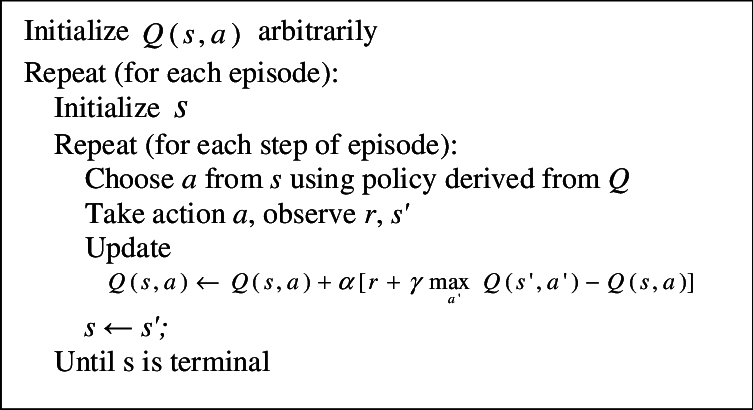

In [34]:

from IPython.display import Image

Image(filename="imgs/Q-earning.png", width=500, height=300)


In [29]:
import numpy as np
import random
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from random import randint
import math

T = (12,12)
K = 12
S = (1,1)

alpha = 0.1
gamma = 0.9
eps = np.random.random_sample()

# -*- coding: utf-8 -*-



# renvoie les dictionnaires comportant les transitions
def dict_transition(K, T, trap):
    
    transitions = {}
    
    for i in range(1, K+1, 1):
        for j in range(1, K+1, 1):
            if((i == K and j == K) or (trap == True and ((1 <= i <= 8 and j == 4) or (5 <= i <= 12 and j == 8)))):
                continue
            # Ensemble des probabilités de déplacement à partir de la case (i,j) selon l'action 
            transitions[(i, j)] = {}
            if(i!=1):
                transitions[(i, j)]["left"] =  (i-1, j)
            if(i!=K):
                transitions[(i, j)]["right"] = (i+1, j)
            if(j!=1):
                transitions[(i, j)]["down"] = (i, j-1)
            if(j!=K):
                transitions[(i, j)]['up'] = (i, j+1)
                
    return transitions

transitions = dict_transition(12, (12,12), False)
transitions_trap = dict_transition(12, (12,12), True)

# renvoie les dictionnaires comportant les récompense
def dict_rewards(K, T, trap):
    
    rewards = {}
    
    for i in range(1, K+1, 1):
        for j in range(1, K+1, 1):
            if(trap == True and ((1 <= i <= 8 and j == 4) or (5 <= i <= 12 and j == 8))):
                rewards[(i,j)] = -2*(K - 1)
            elif (i,j) != T:
                rewards[(i,j)] = -1
            elif (i,j) == T:
                rewards[(i,j)] = 2*(K - 1)
                
    return rewards

rewards = dict_rewards(12, (12,12), False)
rewards_trap = dict_rewards(12, (12,12), True)

# Récupérer les états et les actions
def state_action(K, trap):
    
    # states
    states = []
    for i in range(1,K+1):
        for j in range(1,K+1):
            states.append((i, j))
    
    # actions
    actions = ["up", "down", "left", "right"]
    
    # Paires (states, actions)
    states_actions = []
    for state in states:
        i = state[0]
        j = state[1]
        if(state == T or (trap == True and ((1 <= i <= 8 and j == 4) or (5 <= i <= 12 and j == 8)))):
            states_actions.append((state, None))
            continue
        # Prendre en compte les extrémités
        if(state[0]!=1):
            states_actions.append((state, 'left'))
        if(state[0]!=K):
            states_actions.append((state, 'right'))
        if(state[1]!=1):
            states_actions.append((state, 'down'))
        if(state[1]!=K):
            states_actions.append((state, 'up'))  
    
    return states, actions, states_actions


# Initialiser la fonction de valeur ou la q fonction
def dict_function(states, T):
    
    value_function = {}
    
    for state in states:
        if(state == T):
            value_function[state] = 0
        value_function[state] =  np.random.rand()*10
    
    return value_function


# Faire le choix de l'action en se basant sur les proba que l'action a soit effectué sachant qu'on est dans l'état state
def choice(state, dict_pi, states_actions):
    if((state, None) in states_actions):
        return None
    e = random.uniform(0,1)
    filtered_keys = [(s, a) for s, a in states_actions if s == state]
    proba = [dict_pi[filtered_keys[i]] for i in range(len(filtered_keys))]

    # Calculer des sommes cumulée des proba
    cumulative_sum = proba[0]
    if (cumulative_sum > e):
        return filtered_keys[0][1] # Retourner seulement l'action 
    for i in range(1,len(filtered_keys)):
        cumulative_sum += proba[i]
        if(cumulative_sum > e and cumulative_sum - proba[i] < e):
            return filtered_keys[i][1]
    return filtered_keys[-1][1]

# On construit un chemin en sélectionnant une action en particulière pour chaque état
def construct_path(pi, states_actions, transitions, S, T):
    
    # Liste des états non absorbants
    state_no_absorbing = list(set([t[0] for t in states_actions if t[1]!=None]))
    list_state = [S]
    
    pi_final = {}
    while(S in state_no_absorbing):
        #print(S)
        a = choice(S, pi, states_actions)
        pi_final[S] = [a, transitions[S][a]]
        S = transitions[S][a]
        if(S in list_state):
            return pi_final
        list_state.append(S)
        #print(list_state, " ", S)
    return pi_final

# Obtenir le chemin de la politique optimale
def optimal_policy(pi, rewards, S, T, states_actions):
    
    # Liste des états non absorbants
    state_no_absorbing = list(set([t[0] for t in states_actions if t[1] != None]))
    
    paths = [S]
    reward = [0]
    cpt = 0
    while(S in state_no_absorbing):
        #print(cpt)
        #print("s = ", S)
        if(cpt > 100):
            print("Chemin infini")
            r = -100000000000000000
            return paths, r
        paths.append(pi[S][1])
        reward.append(rewards[pi[S][1]])
        S = pi[S][1]
        if(S not in state_no_absorbing and S != T):
            print("Piège")
            return paths, np.sum(reward)/len(paths)
        cpt += 1
    return paths, np.sum(reward)/len(paths)

# Créer une grille pour les fonctions de valeurs
def grid_function_value(dict_function_value, title):
    
    data_frame = pd.DataFrame([(k[0], k[1], v) for k, v in dict_function_value.items()], columns=['x', 'y', 'value function'])
    data_frame_pivot = data_frame.pivot(index='y', columns='x', values='value function')
    data_frame_pivot = data_frame_pivot.sort_index(ascending=False)

    # Créer une heatmap avec Seaborn
    plt.figure(figsize=(16, 16))
    sns.heatmap(data_frame_pivot, annot=True, fmt=".1f")
    plt.title(title + ": Value function" )
    plt.savefig("graphs/" + title + ".png")
    plt.show()




def draw_arrow(ax, position, direction, color):
    ax.arrow(position[0], position[1], direction[0]-position[0], direction[1]-position[1],
             head_width=0.3, head_length=0.3, fc=color, ec='black')


def gridword(pi, K, title, states_actions):
    # Liste des états non absorbants
    state_no_absorbing = list(set([t[0] for t in states_actions if t[1] is not None]))

    # Récupérer seulement les états et pas les actions
    pi_states = {key: pi[key][1] for key in pi.keys()}

    # Création de la figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Dessiner les flèches sur la grille
    S = (1, 1)
    while S in state_no_absorbing:
        position = S
        direction = pi_states[S]
        color = 'red' if S == (11, 12) else 'blue'
        draw_arrow(ax, position, direction, color=color)  # Changez la couleur ici
        S = direction

    # Réglages de l'axe
    ax.set_xticks(np.arange(0, K+1, 1))
    ax.set_yticks(np.arange(0, K+1, 1))
    ax.grid(True)

    # Ajout de titre et de labels d'axe
    plt.title(title)
    plt.xlabel("X-axis Label")
    plt.ylabel("Y-axis Label")

    # Affichage de la figure
    plt.savefig("graphs/" + title + ".png")
    plt.show()




# Calculer la récompense maximale pour un état précis key
def maximum(transitions, state, actions, rewards, gamma, v, states_actions):
    best_rewards = - np.inf
    for action in actions:
        if((state, action) in states_actions):
            new_state = transitions[state][action]
            somme = rewards[new_state] + gamma * v[new_state]
            #print("somme = ", somme)
            if(somme > best_rewards):
                best_rewards = somme
    v[state] = best_rewards
    #print("best_reward = ", best_rewards)
    return v[state]

# Calculer l'action qui maximise la fonction de valeur
def argmax(transitions, state, actions, rewards, gamma, v, pi, states_actions):
    best_action = ""
    best_rewards = - np.inf
    for action in actions:
        if((state, action) in states_actions):
            new_state = transitions[state][action]
            #print(rewards)
            somme = rewards[new_state] + gamma * v[new_state]
            if(somme > best_rewards):
                best_rewards = somme
                best_action = action
    pi[state] = (best_action, transitions[state][best_action])
    return pi[state]

# Initialisation de Q
def initilize_q(states_actions, T, state_no_absorbing):
    q = {}
    for state_action in states_actions:
        if(state_action[0] in state_no_absorbing):
            q[state_action] = np.random.random_sample()
        
        elif(state_action[0] == T):
            q[(state_action[0], None)] = 0
        else:
            q[(state_action[0], None)] = 0
    return q  

# Initialisation de pi
def initilize_pi(states_actions):
    pi = {}
    states = list(set([pair[0] for pair in states_actions if pair[1]!=None]))
    for state in states:
        paires = [pair[1] for pair in states_actions if pair[0] == state]
        index = random.randint(0, len(paires)-1)
        pi[state] = (paires[index], transitions[state][paires[index]])
    return pi  

# implementation of eps-greedy
def maximize_q(q_function, state, actions, alpha, transitions, dict_rewards, dict_pi, eps):

    best_a = ""
    best_q = - math.inf
    #print(best_q)
    
    """
    Prendre en compte les contraintes des états (par ex, on ne peut pas faire down ou left si on est dans l'état (1,1))
    """
    set_action = list(transitions[state].keys())
    #print("state = ", state, "  set_action = ", set_action)
    """
    Chercher l'action "a" maximisant la q_fonction
    """
    list_q = []
    for a in set_action:
        q = q_function[(state, a)]
        #q = calculate_q(q_function, state, a, alpha, phi, dict_prob, dict_rewards, dict_pi)
        if(q > best_q):
            best_q = q
            best_a = a
        list_q.append((q, a))
    #print(list_q)
    #print("best_action", best_a)
    if(best_a not in actions):
        print("problem: best_a = ", best_a)
    """
    Déterminer la politique de l'état state pour chaque action compatibles (avec l'état) 
    """
    for a in set_action:
        #print("a = ", a)
        if(a != best_a):
            dict_pi[(state, a)] = eps/len(set_action)
        else:
            dict_pi[(state, a)] = (1-eps) + eps/len(set_action)
    return dict_pi

# Calculer l'action qui maximise la fonction de valeur
def argmax_q(transitions, state, actions, rewards, gamma, q, pi, states_actions):
    
    set_action = list(transitions[state].keys())
    q_to_maximise = [q[(state, action)] for action in set_action]
    best_a = set_action[q_to_maximise.index(max(q_to_maximise))]
    
    pi[state] = (best_a, transitions[state][best_a])
    
    return pi[state]

def action_maximize_q(q, state):

    set_action = list(transitions[state].keys())
    q_to_maximise = [q[(state, action)] for action in set_action]
    best_a = set_action[q_to_maximise.index(max(q_to_maximise))]
    
    return best_a










# Générer les dictionnaires de transitions  d'états
transitions = dict_transition(K, T, False)
transitions_trap = dict_transition(K, T, True)

# Générer les récompenses 
rewards = dict_rewards(K, T, False)
rewards_trap = dict_rewards(K, T, True)

# Générer les tuples d'éta action
states, actions, states_actions = state_action(K, False)
_, _, states_actions_trap = state_action(K, True)

def qlearning(states_actions, rewards, states, actions, gamma, alpha, eps, T, iteration, transitions):
    
    # Liste des états non absorbants
    state_no_absorbing = list(set([t[0] for t in states_actions if t[1]!=None]))
    
    # Initialisation de Q
    q = initilize_q(states_actions, T, state_no_absorbing)

    pi = {}
    
    for state, action in states_actions:
        if(action != None and (state, action) not in pi):
            pi = maximize_q(q, state, actions, alpha, transitions, rewards, pi, eps)
       
    # Pour chaque épisode
    for episode in range(iteration):
        #print(episode)
        
        nb = random.randint(0, len(state_no_absorbing)-1)
        S =  state_no_absorbing[nb]
        # Choisir une action a depuis s en utilisant la politique spécifiée par Q (par exemple ε-greedy)
        a = choice(S, pi, states_actions)
              
        # Etape de l'épisode
        while(S in state_no_absorbing):
            S_prime = transitions[S][a]
            r = rewards[S_prime]
            # Choisir a_prime
            if (S_prime in state_no_absorbing):
                a_prime = choice(S_prime, pi, states_actions)
            else:
                a_prime = None
                q[(S, a)] = q[(S, a)] + alpha*(r + gamma*q[(S_prime, a_prime)] - q[(S, a)])
                break
                
            q[(S, a)] = q[(S, a)] + alpha*(r + gamma*q[(S_prime, a_prime)] - q[(S, a)])
            pi = maximize_q(q, S, actions, alpha, transitions, rewards, pi, eps)

            S = S_prime
            a = a_prime
            
        eps = 1 / (episode + 2)
        
    return q, pi
      
eps = np.random.random_sample()

"""
Faire idem pour les autres questions
"""


'\nFaire idem pour les autres questions\n'

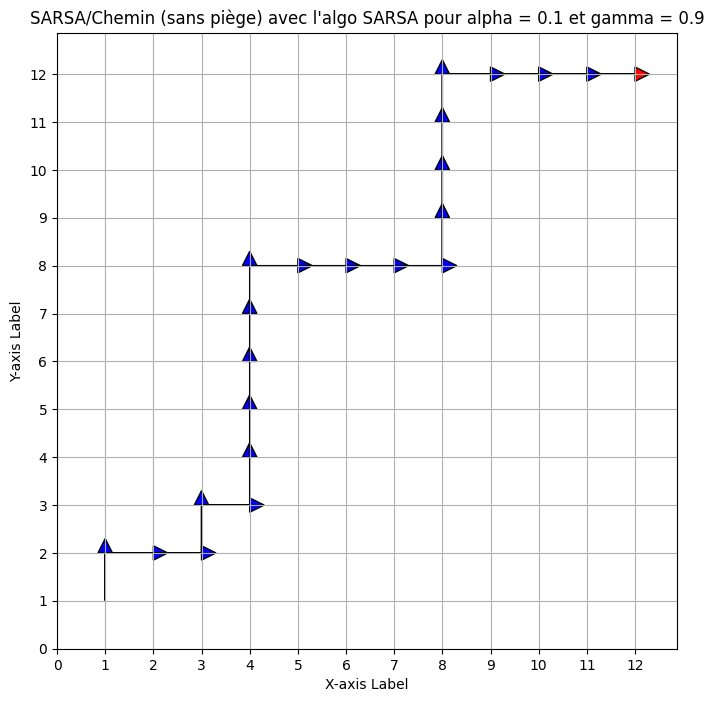

In [30]:
# no trap
q_qlearning, pi_qlearning = qlearning(states_actions, rewards, states, actions, gamma, alpha, eps, T, 10000, transitions)

pi_final_qlearning = construct_path(pi_qlearning, states_actions, transitions, S, T)

paths_qlearning_trap, reward_sarsa = optimal_policy(pi_final_qlearning, rewards, S, T, states_actions)

gridword(pi_final_qlearning, K, "SARSA/Chemin (sans piège) avec l'algo SARSA pour alpha = " + str(alpha) + " et gamma = " + str(gamma), states_actions)


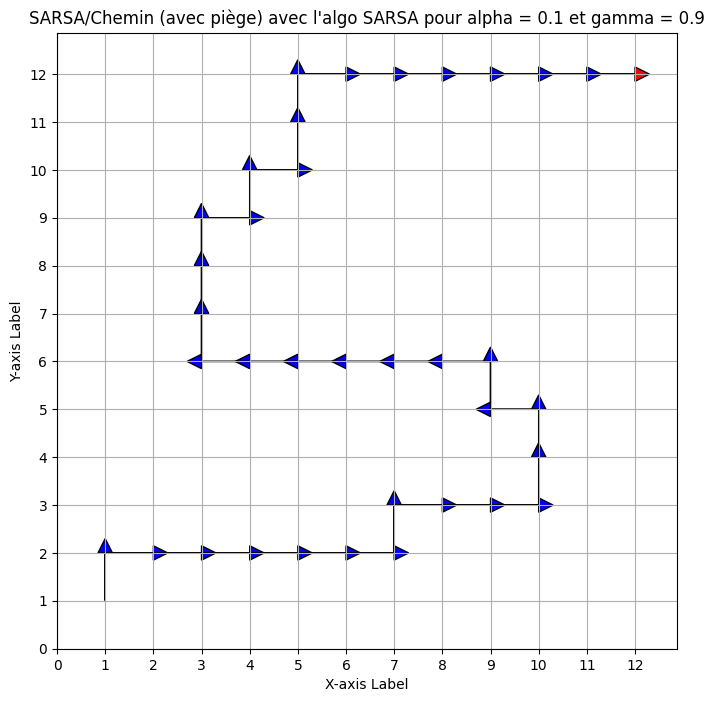

In [32]:
# trap
alpha = 0.1 # Entre 0 et 1
gamma = 0.9
q_sarsa_trap, pi_qlearning_trap = sarsa(states_actions_trap, rewards_trap, states, actions, gamma, alpha, eps, T, 10000, transitions_trap)

pi_final_qlearning_trap = construct_path(pi_qlearning_trap, states_actions_trap, transitions_trap, S, T)
paths_qlearning_trap_trap, reward_qlearning_trap_trap = optimal_policy(pi_final_qlearning_trap, rewards_trap, S, T, states_actions_trap)

gridword(pi_final_qlearning_trap, K, "SARSA/Chemin (avec piège) avec l'algo SARSA pour alpha = " + str(alpha) + " et gamma = " + str(gamma),  states_actions_trap)